In [1]:
import samplerate
from keras import losses
from keras.callbacks import EarlyStopping
from keras.optimizers import adam

import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"]="0"
sys.path.insert(1,'/home/jgozlan/GIT/scripts/')

import random
import matplotlib.pyplot as plt

#from tensorflow import keras
import tensorflow as tf
tf.test.is_gpu_available()

from imu_extractor import get_all_dataframes_for_forecasting
from train_test_split_multi import get_train_test_split
from baseline import get_forecast_baseline_dict, get_mean_acf_peak_value_for_signals,  plot_forecasts_multi
from models import create_lstm_encoder_decoder, create_dropout_predict_function
from evaluation2 import plot_forecasts, plot_metrics, plot_metrics_multi


Using TensorFlow backend.


True

In [4]:
# chooose cluster models to train on or all
path_cluster0 = ['Run_Features','Walk_Features']

path_cluster1 = ['CarDriving_Features']

path_cluster2 = ['Hiking_Features',
                 'Karting_Features',
                 'MotorcycleHelmet_Features',
                 'Scooter_Features','SkateboardChesty_Features',
                 'SnowboardSeeker_Features']

path_all_classes = path_cluster0 + path_cluster1 + path_cluster2

recording_freq = 6400.0
downsampling_freq = 200.0

all_dfs_classes = []

for i,c in enumerate(path_cluster0):
    dfs = get_all_dataframes_for_forecasting("Database/" + c, recording_freq, downsampling_freq)
    all_dfs_classes.append(dfs)
    
all_df = [item for sublist in all_dfs_classes for item in sublist]

GH010029.MP4.eis_dump.bin_features.json
GH010011.MP4.eis_dump.bin_features.json
GH019983.MP4.eis_dump.bin_features.json
GH010019.MP4.eis_dump.bin_features.json
GH010030.MP4.eis_dump.bin_features.json
GH010028.MP4.eis_dump.bin_features.json
GH019982.MP4.eis_dump.bin_features.json
GH010012.MP4.eis_dump.bin_features.json
GH019973.MP4.eis_dump.bin_features.json
GH010018.MP4.eis_dump.bin_features.json
GH019969.MP4.eis_dump.bin_features.json
GH010034.MP4.eis_dump.bin_features.json
GH010014.MP4.eis_dump.bin_features.json
GH019975.MP4.eis_dump.bin_features.json
GH010004.MP4.eis_dump.bin_features.json
GH010005.MP4.eis_dump.bin_features.json
GH010019.MP4.eis_dump.bin_features.json
GH019968.MP4.eis_dump.bin_features.json
GH010035.MP4.eis_dump.bin_features.json
GH019976.MP4.eis_dump.bin_features.json
GH010013.MP4.eis_dump.bin_features.json
GH019980.MP4.eis_dump.bin_features.json
GH010012.MP4.eis_dump.bin_features.json


In [5]:
# sequence creation for forecasting
lag = 500
ahead = 100
delay = 5
test_size = 0.2
dim = 12 # 4 x 3 signals 
target_index = [0,1,2] # gyro x, y, z
classification = False

X_train, y_train, X_test, y_test = get_train_test_split(all_df, test_size, lag, ahead, delay, target_index, classification = False)

In [6]:
# CREATE ENCODER DECODER ARCHITECTURE
encoder_n = 50
decoder_n = 50
in_dim = 12
out_dim = 3
lstm_model = create_lstm_encoder_decoder(encoder_n, decoder_n, lag, ahead, in_dim, out_dim)
lstm_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 500, 12)      0                                            
__________________________________________________________________________________________________
lstm1 (LSTM)                    [(None, 500, 50), (N 12600       input1[0][0]                     
__________________________________________________________________________________________________
lstm2 (LSTM)                    [(None, 50), (None,  20200       lstm1[0][0]                      
__________________________________________________________________________________________________
repeat1 (RepeatVector)          (None, 100, 50)      0           lstm2[0][0]                      
___________

In [7]:
import keras
epochs = 25
batch_size = 64

#MODEL TRAINING

y_train_reshaped = y_train.reshape((-1,ahead,out_dim))
y_test_reshaped = y_test.reshape((-1,ahead,out_dim))

lstm_model.compile(optimizer= adam(),
                   loss= losses.MeanAbsoluteError(),
                   metrics = [keras.metrics.MeanAbsolutePercentageError()])
                  
history_model = lstm_model.fit(X_train, y_train_reshaped,
                               epochs = epochs,
                               validation_data = (X_test,y_test_reshaped),
                               batch_size = batch_size,
                               verbose=1)
                               #callbacks=[early_stopping])



Train on 32151 samples, validate on 6660 samples
Epoch 1/25
11200/32151 [=========>....................] - ETA: 5:00 - loss: 0.0139 - mean_absolute_percentage_error: 303.4490

KeyboardInterrupt: 

In [10]:
# LIST OF BASELINES FOR VISUALIZATION, other choices include the "global model" if global model is loaded
comparison_methods = [ "period acf", "mean","period fourier"]

# None if no global model for visualization.
baseline_dict = get_forecast_baseline_dict(X_test, y_test, None , 3, lag, ahead, downsampling_freq, comparison_methods)

forecast = lstm_model.predict(X_test)
forecast_x = forecast[:,:,0].reshape((forecast.shape[0], forecast.shape[1]))
forecast_y = forecast[:,:,1].reshape((forecast.shape[0], forecast.shape[1]))
forecast_z = forecast[:,:,2].reshape((forecast.shape[0], forecast.shape[1]))

true_x = y_test[:,:,0].reshape((y_test.shape[0], y_test.shape[1]))
true_y = y_test[:,:,1].reshape((y_test.shape[0], y_test.shape[1]))
true_z = y_test[:,:,2].reshape((y_test.shape[0], y_test.shape[1]))

dict_forecasts_x = {"cluster model": forecast_x}
dict_forecasts_y = {"cluster model": forecast_y}
dict_forecasts_z = {"cluster model": forecast_z}

for k, v in baseline_dict.items():
    dict_forecasts_x[k] = v[0]
for k, v in baseline_dict.items():
    dict_forecasts_y[k] = v[1]
for k, v in baseline_dict.items():
    dict_forecasts_z[k] = v[2]

dict_forecasts_color = {"cluster model": "blue", "period acf": "brown","mean":"orange", "period fourier": "yellow","true": "green"}

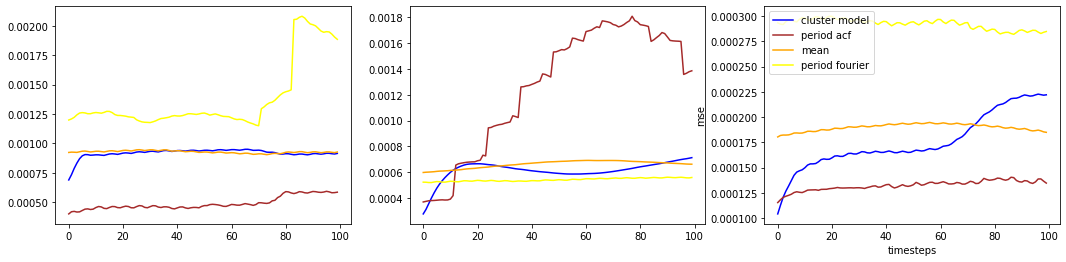

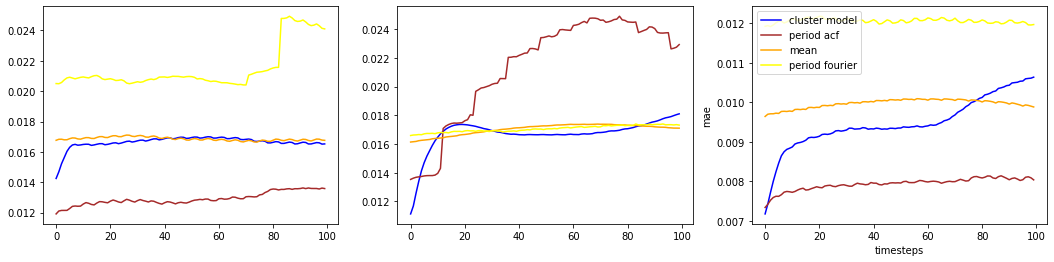

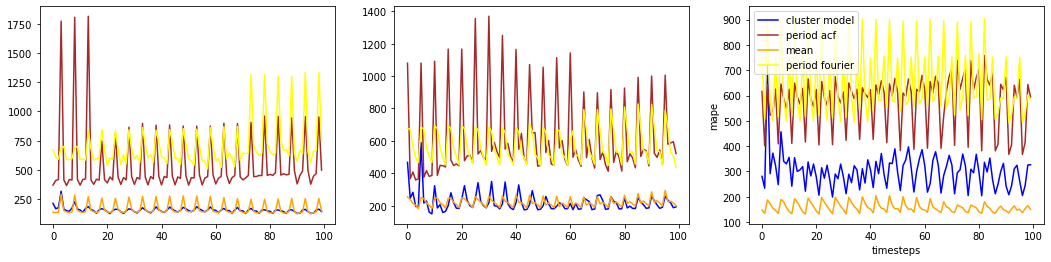

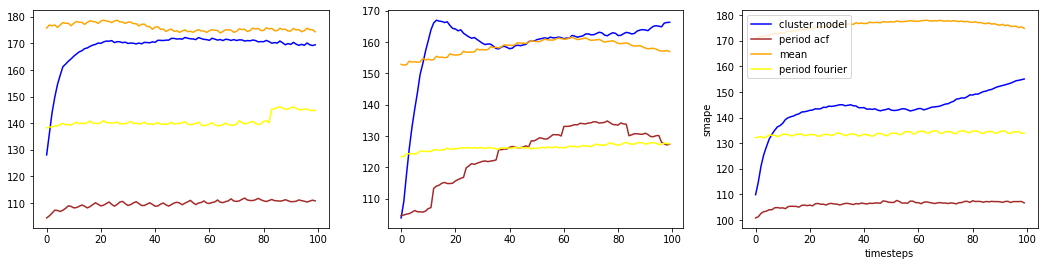

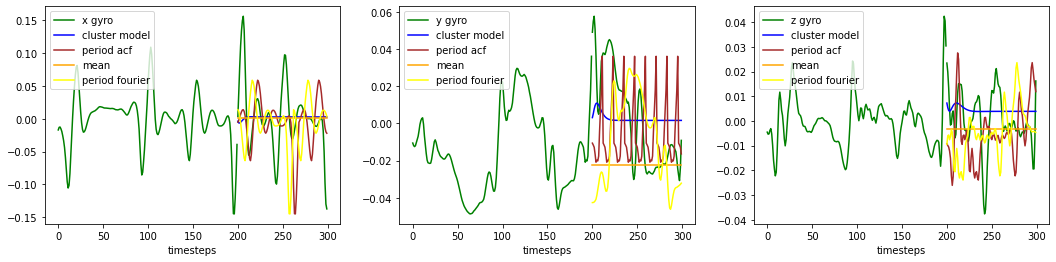

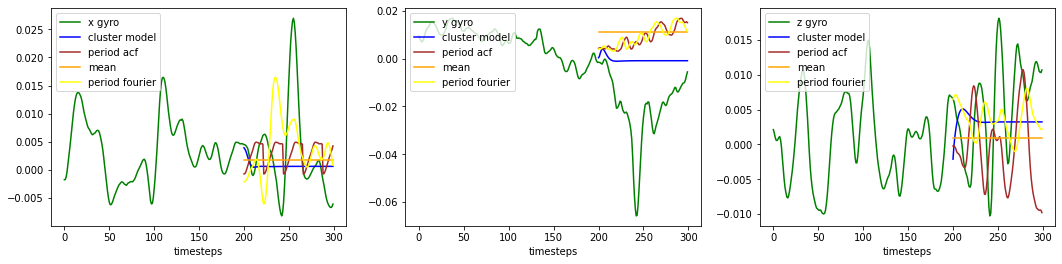

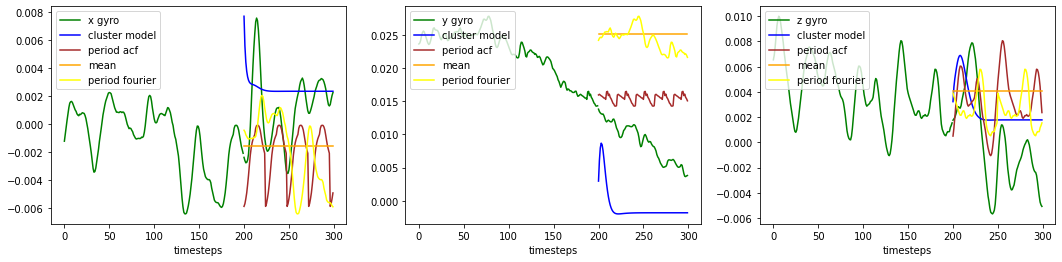

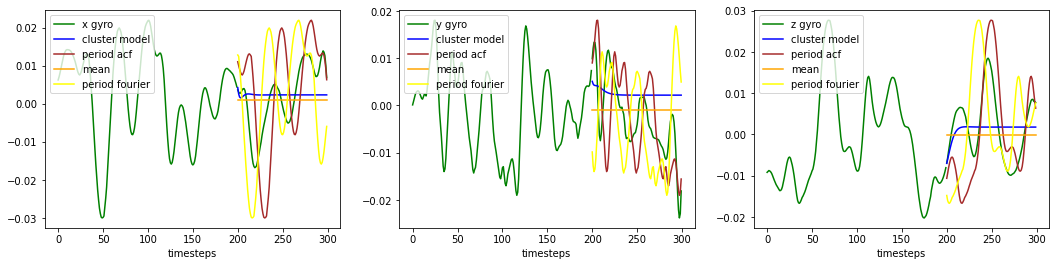

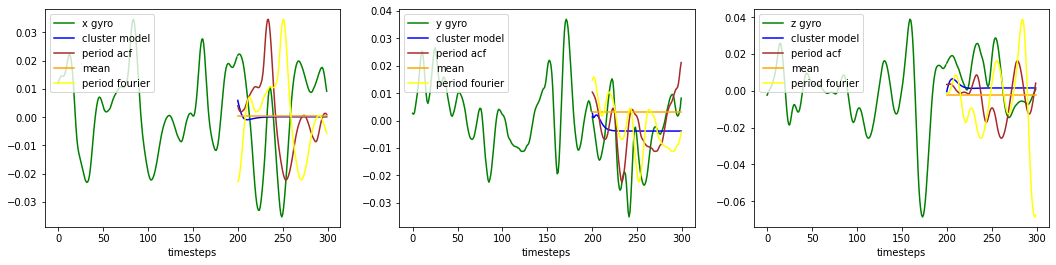

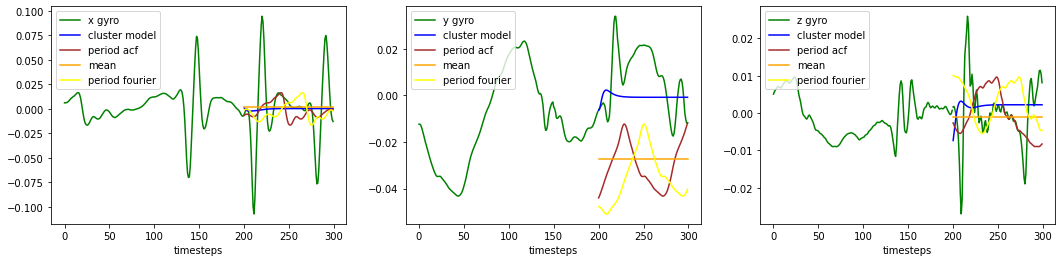

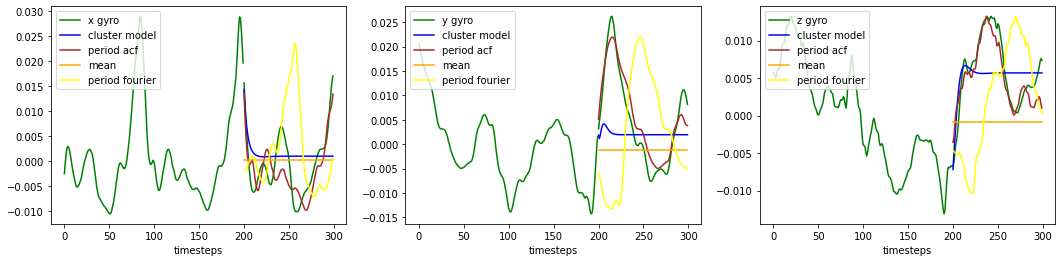

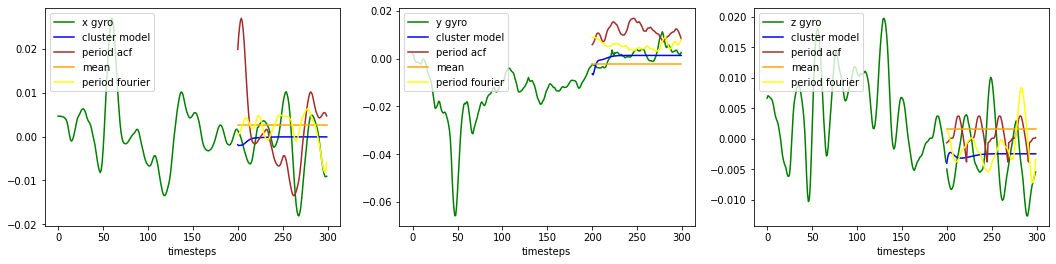

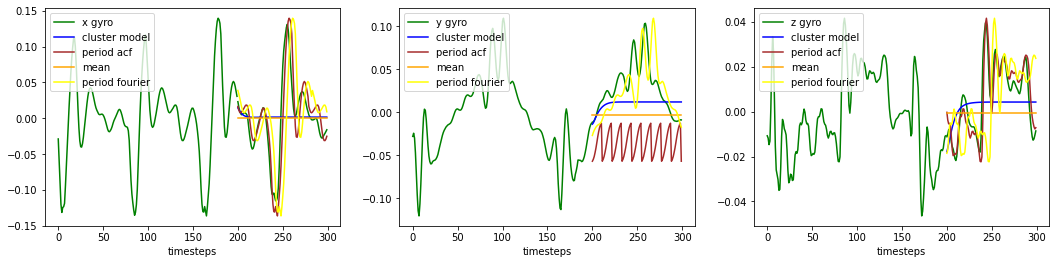

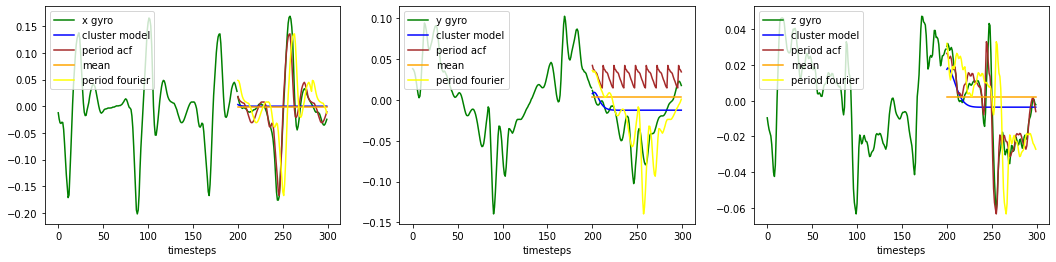

In [11]:
# Plot metrics ( mae, mse, smape, mape), Take as input the true, the dict of baselines/forecast and the associated color)
plot_metrics_multi([true_x, true_y, true_z], [dict_forecasts_x, dict_forecasts_y, dict_forecasts_z], dict_forecasts_color)

# plot some examples.
plot_forecasts_multi(X_test, [true_x, true_y, true_z], [dict_forecasts_x, dict_forecasts_y, dict_forecasts_z], dict_forecasts_color, 10)